In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

%matplotlib inline

In [2]:
train = pd.read_csv('train.csv')

In [3]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749


first_active_month `YYYY-mm` : month of first purchase <br>
We got **Card_ID, Date, 3 anonymized features and target**

Target Variable is some **metric of Quality**,<br>
How good promotions that we send to the client fit his needs

####  Exploring the anonymized features

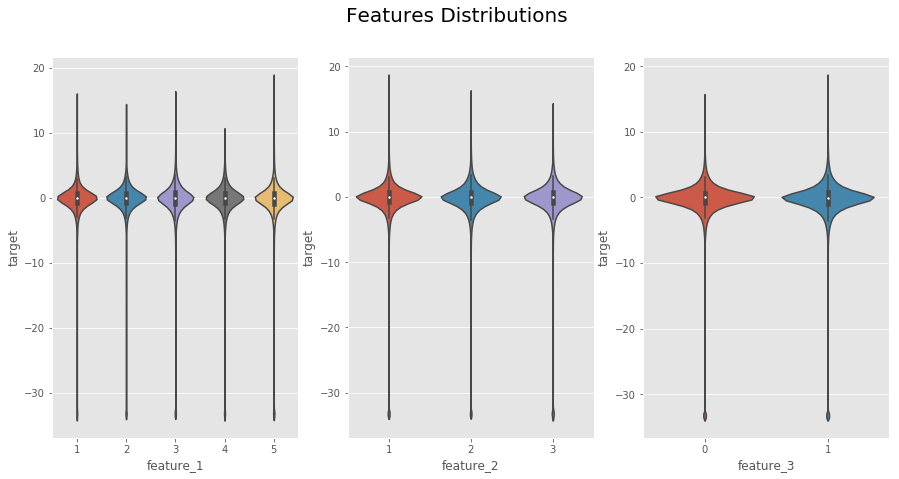

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(15,7), ) 
sns.violinplot(x='feature_1', y='target', data=train, ax= ax[0])
sns.violinplot(x='feature_2', y='target', data=train, ax= ax[1])
sns.violinplot(x='feature_3', y='target', data=train, ax= ax[2])
fig.suptitle('Features Distributions', fontsize=20)
plt.show()

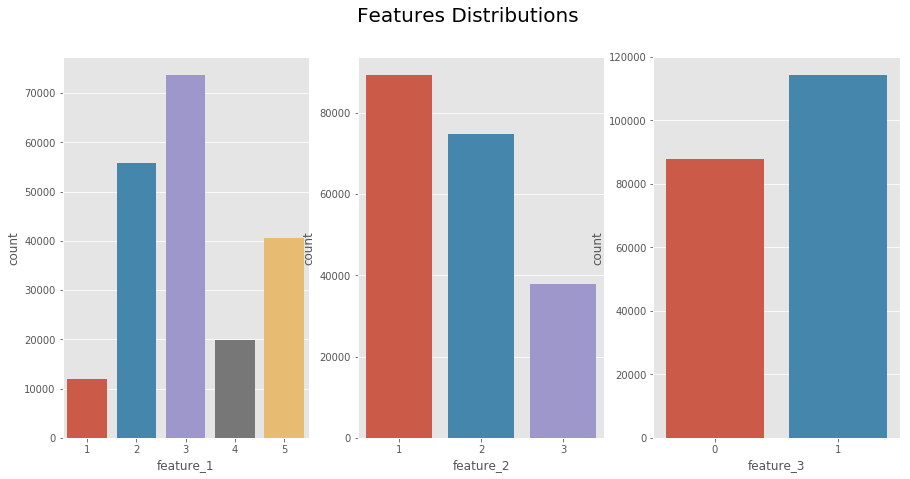

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(15,7), ) 
sns.countplot(train['feature_1'], ax= ax[0])
sns.countplot(train['feature_2'], ax= ax[1])
sns.countplot(train['feature_3'], ax= ax[2])
fig.suptitle('Features Distributions', fontsize=20)
plt.show()

Although They differ in their frequencies .... still have same ***Distribution***, <br> 
##### Note how all features have **mean centered at Zero** which indicates that such Normalization has been applied to such data.

####  target

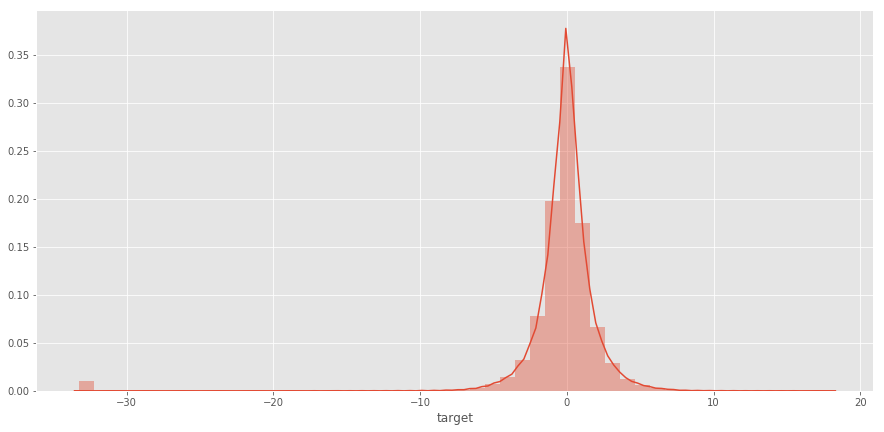

In [6]:
plt.figure(figsize=(15,7)) 
sns.distplot(train.target)
plt.show()

##### Distribution is highly confident with zero centered and low standard deviation, more to notice how some values are far away beyond -30

In [7]:
print("There exist {:,} being treated as outliers,All with same value {}".format(len(train[train.target < -30]), train.loc[train.target < -30, 'target'].head(1).values[0]))

There exist 2,207 being treated as outliers,All with same value -33.21928095


After some thoughts about the target variable ... it seems that it was obfuscated with `log2` transformation <br> 
which make such theory be more practical ... <br>
`
np.log2(x + 0.000_000_000_1) = -33.219280948873624
`<br>
which is the exact same number. at `x = 0`<br><br>
So summarizing what we got, <br>
#### target variable is a ratio of number of promotions used by user divided by total number of promotions sent to such user
which is then tranformed by `log2` with bias `1e-10` to hide such information.<br>
`x = 0` indicate that such customer didn't use any of the promotions recommended for him, may be not suitable promotion for him.


In [8]:
new_merch = pd.read_csv('new_merchant_transactions.csv')
#merchants = pd.read_csv('merchants.csv')

In [9]:
print("New merchant with {:,} observation".format(new_merch.shape[0]))

New merchant with 1,963,031 observation


In [10]:
new_merch.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


In [11]:
new_merch['purchase_amount'].describe()

count    1.963031e+06
mean    -5.509690e-01
std      6.940043e-01
min     -7.468928e-01
25%     -7.166294e-01
50%     -6.748406e-01
75%     -5.816162e-01
max      2.631575e+02
Name: purchase_amount, dtype: float64

Such values are anonymized ... thinking of the most straighforward ways to do so is to demeaning and scaling, which can be reversed using some optimizations and manual tweaking ....<br>
So after reverse the variable with the magic scaling and mean value ... the values now make much more sense 

In [12]:
new_merch['purchase_amount_new'] = pd.Series(np.round(new_merch['purchase_amount'].values / 0.00153 + 500, 2))
new_merch['purchase_amount_new'].sample(10)

1014939    100.21
291998     113.42
1427644     74.19
251101      60.93
1100566     48.80
933133      88.77
471532      27.05
1511992    111.31
1265572    129.68
1865477     19.25
Name: purchase_amount_new, dtype: float64

In [13]:
new_merch['purchase_amount_new'].describe()

count    1.963031e+06
mean     1.398896e+02
std      4.535975e+02
min      1.183000e+01
25%      3.161000e+01
50%      5.893000e+01
75%      1.198600e+02
max      1.724984e+05
Name: purchase_amount_new, dtype: float64

In [14]:
new_merch['purchase_amount_new'].quantile(0.9)

257.26